### Naive Bayes for Document Classification

### Datasets used for the problem:

20Newgroup: Can be downloaded at http://qwone.com/~jason/20Newsgroups/20news-bydate-matlab.tgz The data is composed of six files, three of them contain the test data whilethe other three have the training data. Each row of the train.data and test.data files contain thed ata listed as (docId, wordId, count). The train.label and test.label files contain the labels for each document. The class names for each class are listed in *.map files. You can also download the vocabulary for the dataset from http://qwone.com/~jason/20Newsgroups/vocabulary.txt.

#### Multivariate Bernoulli Model: 
The Bernoulli model for document generation entails flipping|V|coins where|V|is the size of the vocabulary. We will model the documents in the twentywebgroups dataset using the same model, and since we have twenty classes we will beworking with a multinomial class prior distribution.

#### Multinomial Event Model:
In the multinomial event model each document corresponds to independent trials from a multinomial distribution over the vocabulary. This is also known as the unigram model. For this question you will implement the Bernoulli and Multinomial Naive Bayes models for document classification, and compare their performances.
<i>Note: Write in your code only in the place holders where you are instructed to, replacing None.<i>

In [ ]:
# Do not change the code in this cell
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib notebook

In [ ]:
# Change it to inline to show the plots
%matplotlib inline

In [ ]:
# Download the file
!wget http://qwone.com/~jason/20Newsgroups/20news-bydate-matlab.tgz

--2021-06-27 20:42:04--  http://qwone.com/~jason/20Newsgroups/20news-bydate-matlab.tgz
Resolving qwone.com (qwone.com)... 173.48.209.137
Connecting to qwone.com (qwone.com)|173.48.209.137|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7575962 (7.2M) [application/x-gzip]
Saving to: ‘20news-bydate-matlab.tgz’

20news-bydate-matla 100%[===================>]   7.22M  7.85MB/s    in 0.9s    

2021-06-27 20:42:05 (7.85 MB/s) - ‘20news-bydate-matlab.tgz’ saved [7575962/7575962]



In [ ]:
# unzip
!tar zxvf 20news-bydate-matlab.tgz

20news-bydate/matlab/
20news-bydate/matlab/train.data
20news-bydate/matlab/train.label
20news-bydate/matlab/train.map
20news-bydate/matlab/test.data
20news-bydate/matlab/test.label
20news-bydate/matlab/test.map


### Here is the first look at your dataset and its feature columns

In [ ]:
# Change DATA_DIR to the directory containing your data files

DATA_DIR='20news-bydate/matlab'
with open(os.path.join(DATA_DIR, 'train.data')) as f:
    lines = f.readlines()
for l in lines[:5]:
    doc_id,word_id,word_freq = l.strip().split(' ')
    print ('doc_id: {} word_id: {} word frequency: {}'.format(doc_id,word_id,word_freq))
    
with open(os.path.join(DATA_DIR, 'train.label')) as f:
    lines = f.readlines()

for idx,l in enumerate(lines[:5]):
    label = l.strip()
    ## Notice that doc_id starts at 1, not 0.
    print ('doc_id: {} label: {}'.format(idx+1,label))


doc_id: 1 word_id: 1 word frequency: 4
doc_id: 1 word_id: 2 word frequency: 2
doc_id: 1 word_id: 3 word frequency: 10
doc_id: 1 word_id: 4 word frequency: 4
doc_id: 1 word_id: 5 word frequency: 2
doc_id: 1 label: 1
doc_id: 2 label: 1
doc_id: 3 label: 1
doc_id: 4 label: 1
doc_id: 5 label: 1


### Task
Create a word-frequency list across the **training** documents and sort it in descending order from highest frequency to lowest frequency.  
We will be working with vocabulary sizes of |V| $\in$ top{100,500,1000,2500,5000,7500,10000,12500,25000,50000, All}, where “All” is using the complete vocabulary

In [ ]:
# Start code here
# write a function to load the training data from the directory and create a word-frequency list that
# is sorted in descending order from highest frequency to lowest frequency.

def create_word_freq_list(train_data_dir):
    '''
    Your word frequency list shoule be a list of tuples
    [ (word_1_id, word_1_frequence),(word_2_id, word_2_frequence),..., ]
    that is SORTED by word frequency
    '''
    word_freq_dict = {}

    with open(os.path.join(train_data_dir)) as f:
        lines = f.readlines()
    for l in lines:
        doc_id, word_id, word_freq = l.strip().split(' ')
        if word_id in word_freq_dict.keys():
            word_freq_dict[word_id] += int(word_freq)
        else:
            word_freq_dict[word_id] = 1
    word_freq_list = sorted(word_freq_dict.items(), key = lambda kv:(kv[1], kv[0]))
    word_freq_list.reverse()
    return word_freq_list

# End code here

### Task
Write a class for both the Bernoulli Naive-Bayes model and the Multinomial event Naive-Bayes model. The class should fit the model to the training data and evaluate the accuracy on the test data. Keep in mind to restrict the vocabulary to the selected value of |V| for both the training and test sets. Use a simple smoothing model that assigns a default frequency of 1 to each word from the vocabulary.

In [ ]:
# Start code here
import pandas as pd
import numpy as np
import os

class Naive_Bayes:
    def __init__(self, vsize=None, word_freq_list=None,data_dir=None,model_type = 'bernoulli'):
        """
        The init function is already written for you, we pick the top vsize words from the word_freq_list
        and restrict our vocabulary to those words. We do so by constructing a vocab2idx dict that only contain 
        the chosen words. We also init the two parameters that will be learned during training, pi and theta.
        
        vsize: the vocabulary size we pick
        word_freq_list word-frequency list
        data_dir: directory for your data
        model_type: either 'bernoulli' or 'multinomial'
        """
        self.vocab = [int(w[0]) for w in word_freq_list[:vsize]]
        self.vocab = np.array(self.vocab)
        self.vocab_size = vsize
        self.vocab2idx = {w:idx for idx,w in enumerate(self.vocab)}
        self.data_dir=data_dir
        self.model_type = model_type
        
        self.pi = None
        self.theta = None
        
        
    def _doc_vectorize(self,data_dir, model_type = 'bernoulli'):
        """
        Function to read the documents data from the dir and 
        pre-process the documents into a matrix of the shape (num_of_docs, vocab_size)
        Notice that the you need to modify your code for different 
        
        data_dir: directory for your data
        model_type: either 'bernoulli' or 'multinomial'
        
        return the document vectors in a matrix of the shape (num_of_docs, vocab_size)
        """
        with open(os.path.join(data_dir)) as f:
            lines = f.readlines()
        data = []

        for l in lines:
            doc_id, word_id, word_freq = l.strip().split(' ')
            data.append([int(doc_id), int(word_id), int(word_freq)])
        data = np.array(data)
        num_of_docs = np.unique(data[:, 0]).shape[0]
        doc_vecs = np.zeros((num_of_docs, self.vocab_size))

        if model_type == 'bernoulli':
            for i in range(num_of_docs):
                # The data of the document i
                data_doc_i = data[np.where(data[:, 0] == i + 1)]
                # All the word index of the document i
                word_doc_i = data_doc_i[:, 1]
                mask = np.in1d(self.vocab, word_doc_i)
                # The word index of the vocab that in the document
                vacab_index = np.where(mask)[0]
                # Assign 1 to the word index in the doc_vecs matrix
                doc_vecs[i, vacab_index] = 1
        elif model_type == 'multivariate':
            for i in range(num_of_docs):
                # The data of the document i
                data_doc_i = data[np.where(data[:, 0] == i + 1)]
                # All the word index of the document i
                word_doc_i = data_doc_i[:, 1]
                mask = np.in1d(self.vocab, word_doc_i)
                # The word index of the vocab that in the document
                vacab_index = np.where(mask)[0].astype(int)
                # Assign frequency of the word to the doc_vec
                for j in vacab_index:
                    # The index of the vocab that in the data_doc_i 
                    index_of_vocab = np.where(data_doc_i[:, 1] == self.vocab[j])
                    doc_vecs[i, j] = data_doc_i[index_of_vocab, 2]
                #doc_vecs[i, vacab_index] = data_doc_i[word_freq_index, 2]
        doc_vecs = np.array(doc_vecs)
        return doc_vecs
        
    def _label_vectorize(self, label_dir):
        """
        Function to read the labels data from the dir and pre-process (one-hot encoding)
        the labels into a matrix of the shape (num_of_docs, num_of_class)
        
        data_dir: directory for your data
        
        return the label vectors in a matrix of the shape (num_of_docs, num_of_classes)
        """
        #For this problem, we already know num_of_classes = 20
        num_of_classes = 20
        with open(os.path.join(label_dir)) as f:
            lines = f.readlines()
        data = []
        # Read the label
        for l in lines:
            data.append(int(l.strip()))
        # Create the label_vecs matrix
        label_vecs = np.zeros((len(lines), num_of_classes))

        # Assign values to the corresponding point
        for i in range(len(lines)):
            label_vecs[i, data[i] - 1] = 1
        label_vecs = np.array(label_vecs)
        return label_vecs
        
    def fit(self,doc_vecs,label_vecs, model_type = 'bernoulli'):
        """
        Function to learn the two parameters, pi and theta, using the doc-vectors and label-vectors
        we got.
        
        doc_vecs:(num_of_docs, vocab_size)
        label_vecs:(num_of_docs, num_of_classes)
        return:None
        """
        num_docs = doc_vecs.shape[0]
        num_class = label_vecs.shape[1]

        if model_type == 'bernoulli':
            self.pi = np.zeros(num_class)
            self.theta = np.dot(doc_vecs.T, label_vecs) + 1
            for i in range(num_class):
                # class document size, for example, class 1 has 480 documents
                class_doc_size = np.where(label_vecs[:, i] == 1)[0].shape[0]
                self.theta[:, i] /= (class_doc_size + self.vocab_size)
                self.pi[i] = class_doc_size / num_docs
        elif model_type == 'multivariate':
            self.pi = np.zeros(num_class)
            self.theta = np.dot(doc_vecs.T, label_vecs) + 1
            # Get the class word size
            class_word_size = {}
            for k in range(num_class):
                class_word_size[k] = sum(sum(doc_vecs[np.where(label_vecs[:, k] == 1)[0], :]))
            # Calculate theta and pi
            for i in range(num_class):
                # class document size, for example, class 1 has 480 documents
                class_doc_size = np.where(label_vecs[:, i] == 1)[0].shape[0]
                self.theta[:, i] /= (class_word_size[i] + self.vocab_size)
                self.pi[i] = class_doc_size / num_docs
   
    def predict(self,doc_vecs):
        """
        Function to make predictions using the two learned parameters.
        doc_vecs:(num_of_docs, vocab_size)
        
        return: predictions (num_of_docs,), each element is between 0 and num_of_classes (20)
        """
        log_theta = np.log(self.theta)

        prob = np.dot(doc_vecs, log_theta)
        for i in range(self.pi.shape[0]):
            prob[:, i] = prob[:, i] + np.log(self.pi[i])

        prediction = prob.argmax(axis=1)
        return prediction
        
    
    def train(self):
        """
        This function should:
            1. Load the training data and labels
            2. vectorize the data and the labels
            3. fit the parameters
        """
        train_data_dir = os.path.join(self.data_dir, 'test.data')
        train_doc_vecs = self._doc_vectorize(train_data_dir, self.model_type)
        train_label_dir = os.path.join(self.data_dir, 'test.label')
        train_label_vecs = self._label_vectorize(train_label_dir)
        self.vocab_size = train_doc_vecs.shape[1]
        self.fit(train_doc_vecs, train_label_vecs, model_type=self.model_type)
    
    def test(self):
        """
        This function should:
            1. Load the test data and labels
            2. vectorize the data and the labels
            3. apply the (already trained) model to the test data and get predictions
            4. calculate and return the accuracy of the predictions
        """
        # Read test doc data
        test_data_dir = os.path.join(self.data_dir, 'train.data')
        test_doc_vecs = self._doc_vectorize(test_data_dir, self.model_type)
        # Read label data
        test_labrl_dir = os.path.join(self.data_dir, 'train.label')
        test_labels = self._label_vectorize(test_labrl_dir)
        test_labels = test_labels.argmax(axis=1)
        test_predictions = self.predict(test_doc_vecs)
        acc = np.sum(test_labels == test_predictions) / len(test_labels)
        #print(acc)
        return acc

#End code here

### Evaluating the model

In [ ]:
# Set your data_dir
DATA_DIR='20news-bydate/matlab'
# Do not change the code below
train_data_dir = os.path.join(DATA_DIR, 'train.data')
word_freq_list = create_word_freq_list(train_data_dir=train_data_dir)
acc_bernoulli,acc_multi = [],[]
recall_bernoulli,recall_multi = [],[]
precision_bernoulli,precision_multi = [],[]
vsizes = [100,500,1000,2000,5000,20000]
print('Bernoulli Model:')
for vsize in vsizes:
    model_Bernoulli = Naive_Bayes(vsize=vsize, word_freq_list=word_freq_list,data_dir=DATA_DIR,model_type='bernoulli')
    model_Bernoulli.train()
    acc = model_Bernoulli.test()
    acc_bernoulli.append(acc)
    print('Vocabulary size: ' + str(vsize) + '\t Accuracy: ' + str(acc))

print('MultiVariate Model:')
for vsize in vsizes:
    model_MultiVariate = Naive_Bayes(vsize=vsize, word_freq_list=word_freq_list,data_dir=DATA_DIR,model_type='multivariate')
    model_MultiVariate.train()
    acc = model_MultiVariate.test()
    acc_multi.append(acc)
    print('Vocabulary size: ' + str(vsize) + '\t Accuracy: ' + str(acc))



Bernoulli Model:
Vocabulary size: 100	 Accuracy: 0.07445203656047564
Vocabulary size: 500	 Accuracy: 0.173041086165587
Vocabulary size: 1000	 Accuracy: 0.2621350607862277
Vocabulary size: 2000	 Accuracy: 0.3604578933356997
Vocabulary size: 5000	 Accuracy: 0.47697222468719497
Vocabulary size: 20000	 Accuracy: 0.5737864939213773
MultiVariate Model:
Vocabulary size: 100	 Accuracy: 0.2383530038157778
Vocabulary size: 500	 Accuracy: 0.5000443695092732
Vocabulary size: 1000	 Accuracy: 0.6158487887123968
Vocabulary size: 2000	 Accuracy: 0.6800070991214837
Vocabulary size: 5000	 Accuracy: 0.7420356730854557
Vocabulary size: 20000	 Accuracy: 0.7814357973200816


### Evaluation
Plot the accuracy, recall and precision following metrics of the two models versus the vocabulary size. Create three plots for each performance metric.

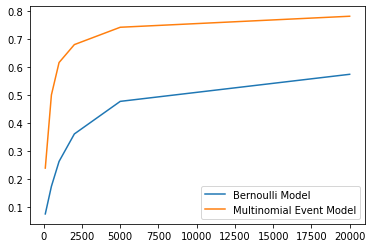

In [ ]:
# Do not change the code in this cell
plt.figure()
plt.plot(vsizes, acc_bernoulli, label = 'Bernoulli Model')
plt.plot(vsizes, acc_multi, label = 'Multinomial Event Model')
plt.legend()
plt.show()